In [1]:
import pandas as pd
import numpy as np
import os

Read data

In [2]:
data_dir = 'news_extracted'

train_df = pd.read_csv(os.path.join(data_dir, 'train.txt'), sep='\t')
val_df = pd.read_csv(os.path.join(data_dir, 'val.txt'), sep='\t')
test_df = pd.read_csv(os.path.join(data_dir, 'test.txt'), sep='\t')

train_df.head()

,ID,TITLE,CATEGORY
0,59266,Jennifer Lopez Drops F-Bomb Whilst Judging 'Am...,Entertainment
1,76495,"GRAINS-Corn, soybeans hit multi-month highs on...",Business
2,85490,Apple Loses Patent-Use Bid in $2 Billion Samsu...,Science and Technology
3,106,McDonald's Blames Weak Sales On Weather,Business
4,27243,George RR Martin Considering 'Game Of Thrones'...,Entertainment


Category distribution

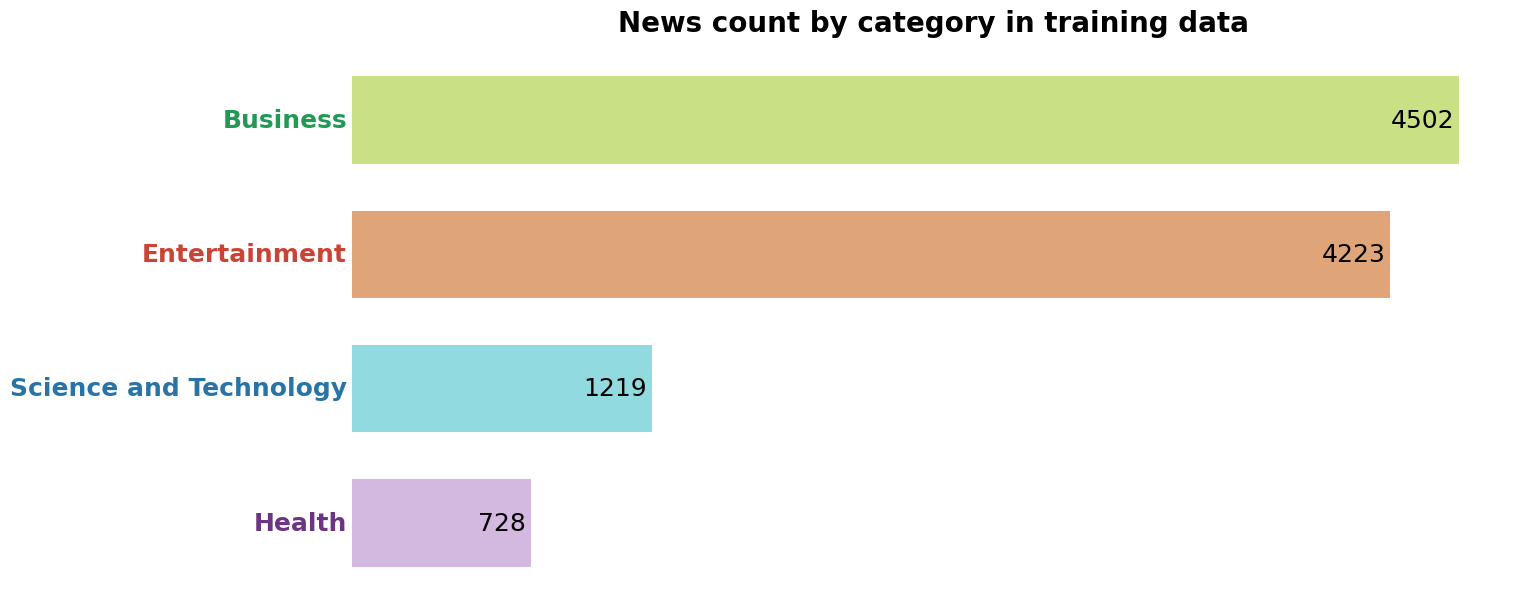

In [3]:
import matplotlib.pyplot as plt

colors = ['#D3B9DF', '#90DAE0', '#E0A479', '#CAE084']
colors_dark = ['#6C3483', '#2874A6', '#CB4335', '#229954']

category = pd.DataFrame(train_df['CATEGORY'].value_counts())
category.columns = ['count']
category = category.sort_values('count', axis=0, ascending=True)

fig = plt.figure(figsize=(15, 7))

plt.barh(width=category['count'], y=category.index, height=0.65,
         color=colors)

for i in range(len(category)):
    plt.text(s=f"{category.index[i]}",
             x=0 - 20, y=i, color = colors_dark[i],
             fontweight='bold', fontsize=18, va='center', ha='right')
    plt.text(s=f"{category['count'].values[i]}",
             x=category['count'].values[i] - 20, y=i, 
             fontweight='medium', fontsize=18, va='center', ha='right')

plt.xlabel('Count')
plt.ylabel('Category')
plt.title('News count by category in training data',
          fontweight='bold', fontsize=20, pad=15)

plt.axis('off')

plt.show()

Preprocess data

In [4]:
from modules.preprocessing import preprocess_text

train_df['TEXT'] = train_df['TITLE'].apply(preprocess_text)
val_df['TEXT'] = val_df['TITLE'].apply(preprocess_text)

train_df.head()

,ID,TITLE,CATEGORY,TEXT
0,59266,Jennifer Lopez Drops F-Bomb Whilst Judging 'Am...,Entertainment,jennifer lopez drop f bomb whilst judge americ...
1,76495,"GRAINS-Corn, soybeans hit multi-month highs on...",Business,grain corn soybeans hit multi month highs stoc...
2,85490,Apple Loses Patent-Use Bid in $2 Billion Samsu...,Science and Technology,apple lose patent use bid billion samsung trial
3,106,McDonald's Blames Weak Sales On Weather,Business,mcdonald s blame weak sales weather
4,27243,George RR Martin Considering 'Game Of Thrones'...,Entertainment,george rr martin consider game thrones movies


In [5]:
# vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=15000)
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

X_train = vectorizer.fit_transform(train_df['TEXT'])
X_val = vectorizer.transform(val_df['TEXT'])

encoder = LabelEncoder()
y_train = encoder.fit_transform(train_df['CATEGORY'])
y_val = encoder.transform(val_df['CATEGORY'])

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((10672, 60323), (1334, 60323), (10672,), (1334,))

In [6]:
class_weight = train_df['CATEGORY'].value_counts(normalize=True).to_dict()

class_weight = {encoder.transform([k])[0]: v for k, v in class_weight.items()}

# to deal with imbalanced classes
inverse_class_weight = {k: 1/v for k, v in class_weight.items()}

inverse_class_weight

{0: 2.370501999111506,
 1: 2.5271134264740707,
 3: 8.754716981132075,
 2: 14.65934065934066}

In [7]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from scipy.sparse import vstack

# Combine training and validation data
X_combined = vstack([X_train, X_val])
y_combined = np.concatenate([y_train, y_val], axis=0)

# Create a predefined split -> tune the hyperparameters on the validation set
test_fold = [-1] * X_train.shape[0] + [0] * X_val.shape[0]
ps = PredefinedSplit(test_fold=test_fold)


In [8]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

base_model = SVC(random_state=42)
model = CalibratedClassifierCV(estimator=base_model)

param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__kernel': ['linear', 'poly', 'rbf'],
    'estimator__class_weight': ['balanced', inverse_class_weight],
    'method': ['sigmoid', 'isotonic']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=ps, n_jobs=-1, verbose=2, scoring='f1_macro')
grid_search.fit(X_combined, y_combined)

# Get the best model
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
Best parameters found:  {'estimator__C': 1, 'estimator__class_weight': {0: 2.370501999111506, 1: 2.5271134264740707, 3: 8.754716981132075, 2: 14.65934065934066}, 'estimator__kernel': 'linear', 'method': 'isotonic'}


In [9]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__class_weight,param_estimator__kernel,param_method,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
19,77.981528,0.0,5.048541,0.0,1,"{0: 2.370501999111506, 1: 2.5271134264740707, ...",linear,isotonic,"{'estimator__C': 1, 'estimator__class_weight':...",0.918803,0.918803,0.0,1
25,80.799408,0.0,4.397477,0.0,10,balanced,linear,isotonic,"{'estimator__C': 10, 'estimator__class_weight'...",0.917604,0.917604,0.0,2
31,78.651661,0.0,4.135897,0.0,10,"{0: 2.370501999111506, 1: 2.5271134264740707, ...",linear,isotonic,"{'estimator__C': 10, 'estimator__class_weight'...",0.916530,0.916530,0.0,3
18,77.907860,0.0,4.779135,0.0,1,"{0: 2.370501999111506, 1: 2.5271134264740707, ...",linear,sigmoid,"{'estimator__C': 1, 'estimator__class_weight':...",0.910991,0.910991,0.0,4
24,78.690350,0.0,4.480133,0.0,10,balanced,linear,sigmoid,"{'estimator__C': 10, 'estimator__class_weight'...",0.909763,0.909763,0.0,5


In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(cm, labels, xrotation=0, yrotation=0):
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_norm, annot=cm, fmt='d', 
                robust=True, 
                cmap="mako_r",
                xticklabels=labels, yticklabels=labels)
    ax.xaxis.tick_top()
    if xrotation != 0:
        plt.xticks(rotation=xrotation, ha='left')
    else:
        plt.xticks(rotation=xrotation)
    plt.yticks(rotation=yrotation)
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()

Test data
                        precision    recall  f1-score   support

              Business     0.9405    0.9538    0.9471       563
         Entertainment     0.9573    0.9773    0.9672       528
                Health     0.8571    0.7912    0.8229        91
Science and Technology     0.8571    0.7895    0.8219       152

              accuracy                         0.9333      1334
             macro avg     0.9030    0.8779    0.8898      1334
          weighted avg     0.9320    0.9333    0.9323      1334



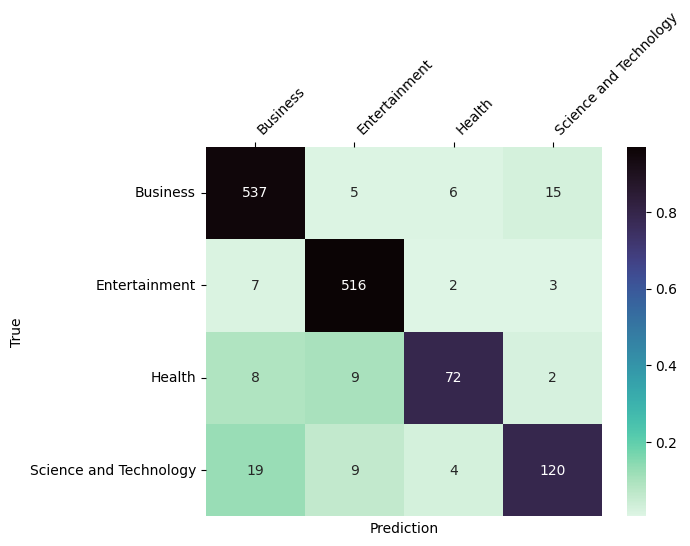

In [14]:
# test
# test_df['TEXT'] = test_df['TITLE'].apply(preprocess_text)

X_test = vectorizer.transform(test_df['TEXT'])
y_test = encoder.transform(test_df['CATEGORY'])

y_test_pred = best_model.predict_proba(X_test)

test_df['PROBA'] = y_test_pred.max(axis=1)
test_df['PRED'] = encoder.inverse_transform(y_test_pred.argmax(axis=1))

print('Test data')
print(classification_report(test_df['CATEGORY'], test_df['PRED'], 
                            target_names=encoder.classes_, digits=4))

cm_test = confusion_matrix(test_df['CATEGORY'], test_df['PRED'])
plot_confusion_matrix(cm_test, encoder.classes_,  xrotation=45)

In [12]:
test_df.loc[test_df['CATEGORY'] != test_df['PRED']].sort_values('PROBA', ascending=False)

,ID,TITLE,CATEGORY,TEXT,PROBA,PRED
1021,93208,PRESS DIGEST - Hong Kong - April 8,Entertainment,press digest hong kong april,0.988998,Business
920,294035,Same engineer designed switches on 5.95 millio...,Business,engineer design switches million recall gm cars,0.972520,Science and Technology
663,378634,The coolest cooler ever: Ice box contains all ...,Science and Technology,coolest cooler ice box contain ingredients party,0.969139,Entertainment
494,93147,This Tiny But Significant Cup Just Sold For A ...,Entertainment,tiny significant cup sell whopping million,0.946847,Science and Technology
804,166993,LG Electronics says higher TV marketing could ...,Science and Technology,lg electronics say higher tv marketing blunt q...,0.941290,Business
...,...,...,...,...,...,...
511,286181,Amazon under investigation after worker was cr...,Business,amazon investigation worker crush death huge,0.418495,Health
845,95231,The electrical implant that can zap the paraly...,Health,electrical implant zap paralysed move,0.412825,Entertainment
1224,28097,Poor Diagnosis Driving Multidrug-Resistant Tub...,Health,poor diagnosis drive multidrug resistant tuber...,0.370762,Business
776,359167,Stressed at work? Meditating really does work ...,Health,stress work meditate work ll difference,0.365681,Entertainment


In [13]:
# save model
import joblib

if not os.path.exists('model'):
    os.makedirs('model')

joblib.dump(model, 'model/classifier.pkl')
joblib.dump(vectorizer, 'model/vectorizer.pkl')
joblib.dump(encoder, 'model/label_encoder.pkl')

['model/label_encoder.pkl']